### Import liabraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

### Load data set

In [51]:
data = pd.read_csv('ai4i2020.csv')

In [52]:
print(data.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [53]:
print(data.shape)

(10000, 14)


### Data Cleaning and Preprocessing

In [54]:
print(data.isnull().sum())

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [55]:
data.fillna(0, inplace=True)
print("\nAfter Filling Missing Values:")
print(data.isnull().sum())


After Filling Missing Values:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


### Feature Engineering

##### 1) Cumulative tool wear

In [56]:
data['Cumulative_Tool_Wear'] = data['Tool wear [min]'].cumsum()

In [57]:
print("\nCumulative Tool Wear Added:")
print(data['Cumulative_Tool_Wear'])


Cumulative Tool Wear Added:
0             0
1             3
2             8
3            15
4            24
         ...   
9995    1079416
9996    1079433
9997    1079455
9998    1079480
9999    1079510
Name: Cumulative_Tool_Wear, Length: 10000, dtype: int64


#### 2) Temperature difference

In [58]:
data['Temp_Difference'] = data['Process temperature [K]'] - data['Air temperature [K]']

In [59]:
print(data['Temp_Difference'])

0       10.5
1       10.5
2       10.4
3       10.4
4       10.5
        ... 
9995     9.6
9996     9.5
9997     9.6
9998     9.7
9999     9.7
Name: Temp_Difference, Length: 10000, dtype: float64


#### 3) Torque per rotation

In [60]:
data['Torque_Per_Rotation'] = data['Torque [Nm]'] / data['Rotational speed [rpm]']

In [61]:
print(data['Torque_Per_Rotation'])

0       0.027595
1       0.032884
2       0.032977
3       0.027565
4       0.028409
          ...   
9995    0.018392
9996    0.019485
9997    0.020304
9998    0.034446
9999    0.026800
Name: Torque_Per_Rotation, Length: 10000, dtype: float64


#### 4) Failure Indicator

In [62]:
data['Any_Failure'] = (data['TWF'] + data['HDF'] + data['PWF'] + data['OSF'] + data['RNF']).apply(lambda x: 1 if x > 0 else 0)

In [63]:
print(data['Any_Failure'])

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Any_Failure, Length: 10000, dtype: int64


#### 5) Time-based feature

In [64]:
data['time_sequence'] = range(1, len(data) + 1)

In [65]:
print(data['time_sequence'])

0           1
1           2
2           3
3           4
4           5
        ...  
9995     9996
9996     9997
9997     9998
9998     9999
9999    10000
Name: time_sequence, Length: 10000, dtype: int64


#### 6) Rolling statistics

In [66]:
data['rolling_mean_torque'] = data['Torque [Nm]'].rolling(window=5).mean()
data['rolling_std_torque'] = data['Torque [Nm]'].rolling(window=5).std()
data['rolling_sum_tool_wear'] = data['Tool wear [min]'].rolling(window=5).sum()
data['rolling_max_temp_diff'] = data['Temp_Difference'].rolling(window=5).max()
data['rolling_min_temp_diff'] = data['Temp_Difference'].rolling(window=5).min()
data.fillna(0, inplace=True)  # Fill NaN values created by rolling

In [67]:
print("\nRolling Statistics Added:")
print(data[['rolling_mean_torque', 'rolling_std_torque', 'rolling_sum_tool_wear', 'rolling_max_temp_diff', 'rolling_min_temp_diff']].head())


Rolling Statistics Added:
   rolling_mean_torque  rolling_std_torque  rolling_sum_tool_wear  \
0                  0.0             0.00000                    0.0   
1                  0.0             0.00000                    0.0   
2                  0.0             0.00000                    0.0   
3                  0.0             0.00000                    0.0   
4                 43.6             4.22315                   24.0   

   rolling_max_temp_diff  rolling_min_temp_diff  
0                    0.0                    0.0  
1                    0.0                    0.0  
2                    0.0                    0.0  
3                    0.0                    0.0  
4                   10.5                   10.4  


### Data Visualization

#### 1) Heat Map

C:\Users\user\AppData\Local\Temp\ipykernel_17748\50629991.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


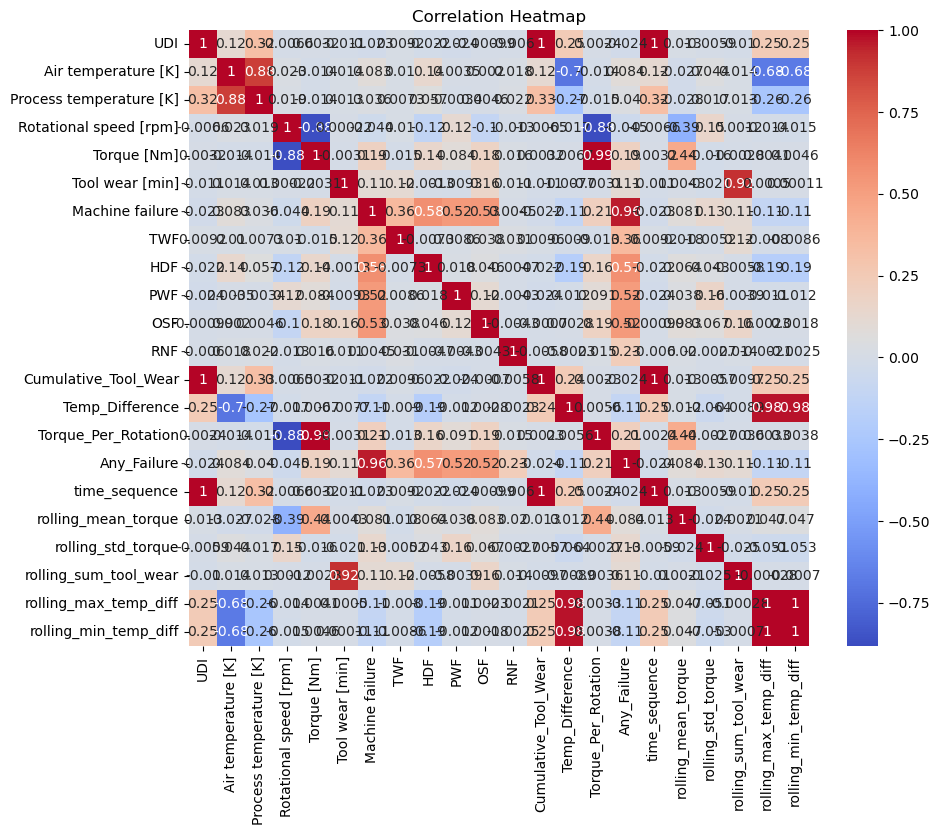

In [68]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

#### 2) Distribution of Machine Failure

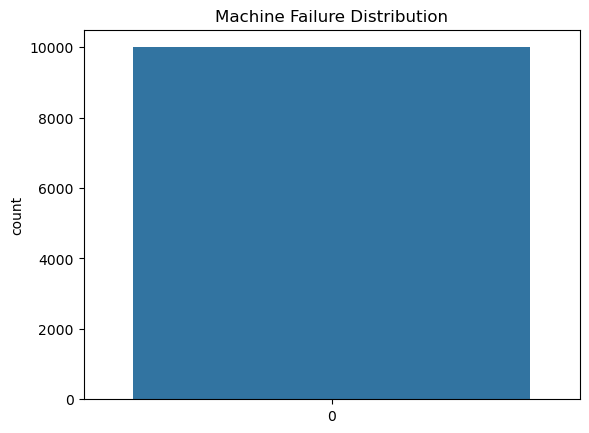

In [69]:
sns.countplot(data['Machine failure'])
plt.title("Machine Failure Distribution")
plt.show()

#### 4) Rolling Statistics

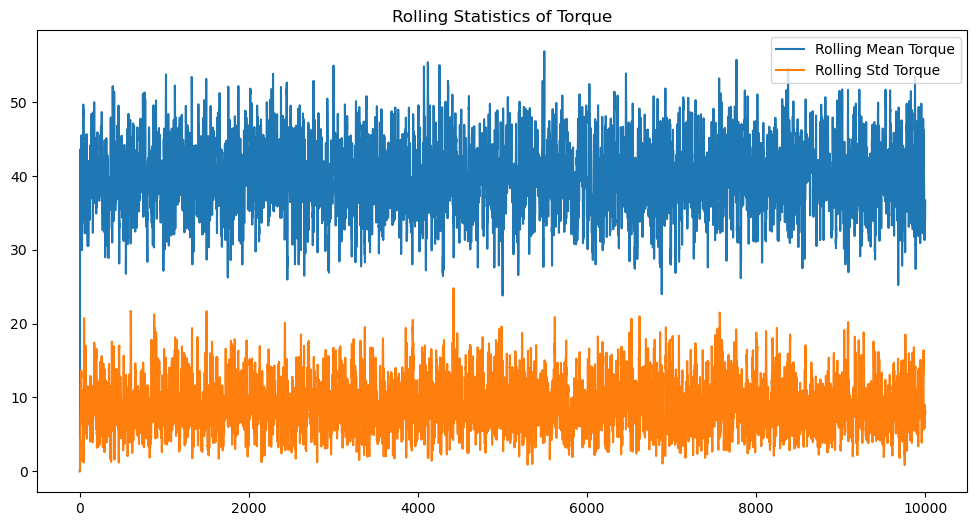

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(data['time_sequence'], data['rolling_mean_torque'], label='Rolling Mean Torque')
plt.plot(data['time_sequence'], data['rolling_std_torque'], label='Rolling Std Torque')
plt.legend()
plt.title("Rolling Statistics of Torque")
plt.show()

###  Prepare Data for Model

#### 1)  Encoding categorical column

In [71]:
data = pd.get_dummies(data, columns=['Type'], drop_first=True)

#### 2) Define Features (X) and Target (y)

In [72]:
X = data.drop(columns=['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
y = data['Machine failure']

#### 3) Split data 

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
print("\nTrain-Test Split Completed!")
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")


Train-Test Split Completed!
Training Data Shape: (8000, 17)
Testing Data Shape: (2000, 17)


### Train the Model

In [75]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
print("\nModel Training Completed!")


Model Training Completed!


### Evaluate the Model

#### 1) Predictions

In [76]:
y_pred = model.predict(X_test)

#### 2) Accuracy

In [77]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 99.60%


#### 3) Confusion Matrix

In [78]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[1933    6]
 [   2   59]]


#### 4) Classification Report

In [79]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       0.91      0.97      0.94        61

    accuracy                           1.00      2000
   macro avg       0.95      0.98      0.97      2000
weighted avg       1.00      1.00      1.00      2000



### Save Result

In [80]:
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = y_pred

results.to_csv('model_predictions.csv', index=False)
print("\nPredictions Saved to 'model_predictions.csv'")


Predictions Saved to 'model_predictions.csv'
